# Automated Hyperparameter Tuning with CV
[캐글 페이지](https://www.kaggle.com/code/pavansanagapati/automated-hyperparameter-tuning)

최적의 하이퍼파라미터 세트를 선택하기 위한 방법들을 정리.

## 1. introduction

하이퍼파라미터는 학습 전에 값을 설정하는 매개변수이다.

일반적으로 아래 그림과 같이 최적의 파라피터를 찾는다.
![](https://developer.qualcomm.com/sites/default/files/attachments/learning_resources_03-05.png)

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# 신용 카드 사기 탐지 데이터 세트
df = pd.read_csv('./data/creditcard.csv',na_values = '#NAME?')

# 신용카드 데이터이기에 특징에 대한 설명이 없다. 주어진 특징들을 기반으로 사기인지 아닌지를 판단.
X = df[['V17', 'V9', 'V6', 'V12']]
Y = df['Class']

In [4]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30,random_state = 101)

## 2. 수동 검색

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [22]:
# 모델을 Random Forest Classifier을 사용.
model = RandomForestClassifier(random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc1 = accuracy_score(Y_Test,predictionforest)

[[85289    10]
 [   34   110]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.92      0.76      0.83       144

    accuracy                           1.00     85443
   macro avg       0.96      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



수동 검색이라는 말 그래로 직접 매개변수를 경험적으로 변경하여 선택한다.  

  [Random Forest Classifier의 주요 매개변수](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* criterion : 분할 품질을 측정하는 기능. {“gini”, “entropy”, “log_loss”}, default=”gini”
* max_depth : 각 트리에 허용되는 최대 수준 수 
* max_features : 노드를 분할할 때 고려되는 최대 features 수. {“sqrt”, “log2”, None}, int 또는 float, default=”sqrt”
* min_samples_leaf : tree leaf에 저장할 수 있는 최소 샘플 수.
* min_samples_split : 노드 분할하기 위해 노드에 필요한 최소 샘플 수.
* n_estimators : 앙상블의 tree 수.

In [38]:
model2 = RandomForestClassifier(n_estimators=10, max_depth=2, random_state= 101).fit(X_Train,Y_Train)
predictionforest = model2.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc2 = accuracy_score(Y_Test,predictionforest)

[[85276    23]
 [   41   103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.82      0.72      0.76       144

    accuracy                           1.00     85443
   macro avg       0.91      0.86      0.88     85443
weighted avg       1.00      1.00      1.00     85443



---------
confusion matrix
* TN : False를 **False**라고 예측한 개수 85289
* TP : True를 **True**라고 예측한 개수 110
* FP : False를 **True**라고 예측한 개수 10
* FN : True를 **False**라고 예측한 개수 34

Precision(정밀도) : 사기라고 예측한 경우중에서 실제 사기인 비율
$$precision=\frac{TP}{TP+FP}$$

Recall(재현율) : 실제 사기인 경우중 사기라고 예측한 비율
$$recall=\frac{TP}{TP+FN}$$

f1-score : 정밀도와 재현율의 조화 평균
$$F1=2\cdot precision\cdot recall / (precision+recall)

Support: 각 클래스의 실제 데이터 수   

In [39]:
print(model.get_params())
print(model2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 101, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 101, 'verbose': 0, 'warm_start': False}


## 3. Grid Search
하이퍼파라미터 그리드를 설정하고 각 조합에 대한 학습을 진행하여 선택
scikit-learn의 GridSearchCV() 함수를 사용.

In [74]:
from sklearn.model_selection import GridSearchCV

grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'min_samples_leaf': [4, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20,50]}

clf = RandomForestClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = 1)
model.fit(X_Train,Y_Train)

predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc3 = accuracy_score(Y_Test,predictionforest)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV 1/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=20;, score=0.999 total time=   2.2s
[CV 2/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=20;, score=0.999 total time=   2.2s
[CV 3/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=20;, score=0.999 total time=   2.2s
[CV 4/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=20;, score=0.999 total time=   2.2s
[CV 1/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.999 total time=   5.6s
[CV 2/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.999 total time=   5.5s
[CV 3/4] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.999 total time=  

In [75]:
print("Best Score: ", model.best_score_)
model.best_params_

Best Score:  0.9991924319335487


{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

## 4. Random Search
Grid Search와 같이 그리드를 설정하고, 그리드 내에서 랜덤적으로 조합을 만들어 정한 개수만큼 학습하여 비교한다.

In [76]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'min_samples_leaf': [4, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20,50]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = 1)
model.fit(X_Train,Y_Train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.999 total time=   4.9s
[CV 2/4] END criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.999 total time=   4.9s
[CV 3/4] END criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.999 total time=   4.9s
[CV 4/4] END criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.999 total time=   4.8s
[CV 1/4] END criterion=entropy, max_depth=2, min_samples_leaf=8, min_samples_split=10, n_estimators=20;, score=0.999 total time=   2.1s
[CV 2/4] END criterion=entropy, max_depth=2, min_samples_leaf=8, min_samples_split=10, n_estimators=20;, score=0.999 total time=   2.1s
[CV 3/4] END criterion=entropy, max_depth=2, min_samples_leaf=8, min_samples_split=10, n_estimators=20;, score=0.999 total time=   2.1s
[CV

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2],
                                        'min_samples_leaf': [4, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [20, 50]},
                   random_state=101, verbose=5)

In [77]:
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc4 = accuracy_score(Y_Test,predictionforest)

[[85280    19]
 [   40   104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.85      0.72      0.78       144

    accuracy                           1.00     85443
   macro avg       0.92      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443



훈련 후 하이퍼파라미터 중 일부에 대한 영향을 확인 할 수 있다.

<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

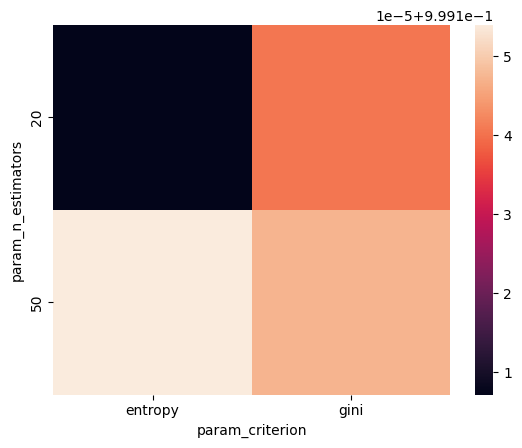

In [78]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

## 5. Automated Hyperparameter Tuning
![](https://better.future-processing.com/directus/storage/uploads/2399317284eda5016daac68812d5d3c3.png)

모델을 이용하여 하이퍼파라미터를 선택. (베이지안 최적화, 경사하강법, 진화알고리즘)

### Bayesian Optimization using HyperOpt

베이지안 최적화(Baysian Optimization)을 이용하여 최적의 하이퍼파라미터 선택, Random search 보다 빠르다.

Hyeropt 라이브러리를 사용하여 python에서 수행 가능. 

Hyperopt의 fmin()를 사용하여 베이지안 최적화를 구현.
* Objective Function = 최소화할 손실 함수를 정의.
* Domain Space = 테스트할 입력 값의 범위를 정의(베이지안 최적화에서 이 공간은 사용된 각 하이퍼파라미터에 대한 확률 분포를 생성).
* Optimization Algorithm = 각각의 새로운 반복에서 사용할 최상의 입력 값을 선택하는 데 사용할 검색 알고리즘을 정의.

In [87]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# 
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.choice('max_depth', np.arange(10, 12, dtype=int)),
        'max_features': hp.choice('max_features', ['sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [20, 50])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_Train, Y_Train, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
best

100%|██████████| 20/20 [02:28<00:00,  7.45s/trial, best loss: -0.9982544491482915]


{'criterion': 1,
 'max_depth': 0,
 'max_features': 2,
 'min_samples_leaf': 0.20537311526071755,
 'min_samples_split': 0.19752606483187185,
 'n_estimators': 1}

In [88]:
crit = {0: 'entropy', 1: 'gini'}
dep = {0:10, 1:11, 2:12}
feat = {0: 'sqrt', 1: 'log2', 2: None}
est = {0: 20, 1: 50}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = dep[best['max_depth']], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X_Train,Y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))
acc5 = accuracy_score(Y_Test,predictionforest)

[[85299     0]
 [  144     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.00      0.00      0.00       144

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



C:\Users\qntjr\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qntjr\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qntjr\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Genetic Algorithms using TPOT

### Artificial Neural Networks (ANNs) Tuning

## 6. Optuna

## 7. Tune

## 8. Sherpa